In [3]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
import ast
from datetime import datetime, timedelta

In [4]:
# from transformers import MarianMTModel, MarianTokenizer
# from sentence_transformers import SentenceTransformer, util

In [5]:
# 加载数据
file_path_1="promed_mail.csv"
df_promed = pd.read_csv(file_path_1)

#df_promed = pd.read_excel(file_path, sheet_name='epidemic_event_news_20240605170')

In [6]:
file_path_2="sqlResult_1.csv"
df_full = pd.read_csv(file_path_2)

In [7]:
df_promed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64170 entries, 0 to 64169
Data columns (total 34 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   data_unique         64170 non-null  float64
 1   title_orig          64170 non-null  object 
 2   title_cn            63993 non-null  object 
 3   description_orig    64170 non-null  object 
 4   description_cn      63995 non-null  object 
 5   content_orig        64170 non-null  object 
 6   content_cn          0 non-null      float64
 7   date_published      64170 non-null  object 
 8   lang                0 non-null      float64
 9   countries           42319 non-null  object 
 10  locations           0 non-null      float64
 11  source_url          64168 non-null  object 
 12  source_database     64170 non-null  object 
 13  download_url        0 non-null      float64
 14  categories          0 non-null      float64
 15  event_id            0 non-null      float64
 16  see_

In [8]:
df_promed.head()

,data_unique,title_orig,title_cn,description_orig,description_cn,content_orig,content_cn,date_published,lang,countries,...,is_unknown_disease,is_multi_countries,is_human_disease,death_count,create_time,update_time,disease_orig,country_orig,label_json,label_update_time
0,2.024063e+07,Undiagnosed deaths: Thailand (Nakhon Phanom) b...,NaN,PRO/MBDS> Undiagnosed deaths: Thailand (Nakhon...,NaN,UNDIAGNOSED DEATHS: THAILAND (NAKHON PHANOM) B...,NaN,2024-06-30 04:00:14,NaN,"[""泰国""]",...,NaN,NaN,NaN,NaN,2024-06-30 04:15:41,2024-07-01 00:20:22,NaN,"[{""0"":""c1"",""1"":""Thailand"",""2"":""15.127040"",""3"":...",NaN,NaN
1,2.024063e+07,"Avian influenza (88): China (ZJ) HPAI H5N6, wi...",NaN,PRO/AH/EDR> Avian influenza (88): China (ZJ) H...,NaN,AVIAN INFLUENZA (88): CHINA (ZHEJIANG) HPAI H5...,NaN,2024-06-30 03:12:16,NaN,"[""中国""]",...,NaN,NaN,NaN,NaN,2024-06-30 04:04:16,2024-07-01 00:27:00,NaN,"[{""0"":""c1"",""1"":""China"",""2"":""36.519981"",""3"":""10...",NaN,NaN
2,2.024063e+07,"Hepatitis C - China: (HK) nosocomial, suspected",NaN,"PRO/EDR> Hepatitis C - China: (HK) nosocomial,...",NaN,"HEPATITIS C - CHINA: (HONG KONG) NOSOCOMIAL, S...",NaN,2024-06-30 03:07:26,NaN,NaN,...,NaN,NaN,NaN,NaN,2024-06-30 04:04:19,2024-07-01 00:27:00,NaN,"[{""0"":""c1"",""1"":""China"",""2"":""36.519981"",""3"":""10...",NaN,NaN
3,2.024063e+07,Crimean-Congo hem. fever - Asia (12): Turkiye ...,NaN,PRO/AH/EDR> Crimean-Congo hem. fever - Asia (1...,NaN,CRIMEAN-CONGO HEMORRHAGIC FEVER - ASIA (12): T...,NaN,2024-06-30 01:41:56,NaN,NaN,...,NaN,NaN,NaN,NaN,2024-06-30 02:01:38,2024-07-01 00:27:00,NaN,"[{""0"":""c3"",""1"":""Turkiye"",""2"":""39.060600"",""3"":""...",NaN,NaN
4,2.024063e+07,Anthrax - India (03): (OR) human,NaN,PRO/AH/EDR> Anthrax - India (03): (OR) human,NaN,ANTHRAX - INDIA (03): (ODISHA) HUMAN\n********...,NaN,2024-06-30 01:41:46,NaN,"[""印度""]",...,NaN,NaN,NaN,NaN,2024-06-30 02:03:36,2024-07-01 00:27:00,NaN,"[{""0"":""c3"",""1"":""India"",""2"":""22.883480"",""3"":""79...",NaN,NaN


In [9]:
news_null_counts = df_promed.isnull().sum()
#print(df_promed.info())
print(news_null_counts)

data_unique               0
title_orig                0
title_cn                177
description_orig          0
description_cn          175
content_orig              0
content_cn            64170
date_published            0
lang                  64170
countries             21851
locations             64170
source_url                2
source_database           0
download_url          64170
categories            64170
event_id              64170
see_also              64170
files                 64170
disease_name          21019
disease_pathogen      64170
is_virus_related      64170
is_drug_resist        64170
is_vector_borne       64170
is_respiratory        64170
is_unknown_disease    64170
is_multi_countries    64170
is_human_disease      64170
death_count           64170
create_time               0
update_time               0
disease_orig          64170
country_orig              0
label_json            58829
label_update_time     58829
dtype: int64


In [10]:
origs_promed = df_promed['content_orig'].tolist()
#origs_promed

In [11]:
def remove_after_also_see(strings):
    result = []
    for string in strings:
        if "see also" in string:
            new_string= string.split("see also")[0].strip()
            result.append(new_string)
        else:
            result.append(string)
    return result

In [12]:
def remove_special_characters(text):
    if isinstance(text, str):
        # 使用正则表达式去除特殊符号
        return re.sub(r'[^\w\s]', '', text.lower())
    else:
        return ""

In [13]:
df_promed['country_orig'].unique()

array(['[{"0":"c1","1":"Thailand","2":"15.127040","3":"101.017357"}]',
       '[{"0":"c1","1":"China","2":"36.519981","3":"103.891769"}]',
       '[{"0":"c1","1":"China","2":"36.519981","3":"103.891769"},{"0":"l1","1":"Hong Kong","2":"22.284000","3":"114.150002"}]',
       ...,
       '[{"0":"c3","1":"Sudan","2":"13.831530","3":"30.049950"},{"0":"l3","1":"Aweil, Northern Bahr el Ghazal, Sudan","2":"8.765100","3":"27.389400"},{"0":"l3","1":"North Bahr al Ghazal, Sudan","2":"8.733333","3":"26.900000"}]',
       '[{"0":"c1","1":"Cape Verde","2":"15.978970","3":"-23.967791"},{"0":"c1","1":"Cote d\'Ivoire","2":"7.631530","3":"-5.000000"},{"0":"c1","1":"Algeria","2":"28.163240","3":"2.632390"},{"0":"c1","1":"Ethiopia","2":"8.626220","3":"39.616032"},{"0":"c1","1":"Botswana","2":"-22.181999","3":"23.815029"},{"0":"c1","1":"Kenya","2":"0.529860","3":"37.857880"},{"0":"c1","1":"Mauritius","2":"-20.251869","3":"57.870770"},{"0":"c1","1":"Seychelles","2":"-6.354350","3":"52.229939"}]',
       '[{

In [14]:
rows_with_nulls_or_empty_list = df_promed[df_promed["countries"].isnull() | (df_promed["countries"] == '[]')]

In [15]:
rows_with_nulls_or_empty_list["title_orig"].tolist()

['Hepatitis C - China: (HK) nosocomial, suspected',
 'Crimean-Congo hem. fever - Asia (12): Turkiye (TT)',
 'Surveillance (158): India, carbapenem resist. ST16 K. pneumoniae, genomic insights',
 'Surveillance (157): natural compounds, antibacterial & antiviral effects, review',
 'Rocky Mountain spotted fever - Mexico: (CH) fatal',
 'Trichinellosis - Russia: (TO) bear meat',
 'Influenza (06): USA (PA) H1N2v, swine origin, more cases',
 'Tetanus - Israel: (HM) unimmunized child',
 'Avian influenza (40): China, HPAI H5N6, wild bird, WOAH',
 'Hepatitis C - China: (Hong Kong) nosocomial, suspected',
 'Leishmaniasis - Syria: (HA) cutaneous, increasing incidence',
 'Salmonellosis - USA (07): (WA) restaurant, recurrent infections, source not identified',
 'Hepatitis A - Brazil: (PR)',
 'Brucellosis, canine - USA: (SC) human exposure study',
 'Antimicrobial stewardship (161): S. maltophilia, critically ill patients, management',
 'Botulism - USA (07): (CA) family gathering',
 'Carbapenem-resist

### Timeliness

In [17]:
df_promed['date_published']

0        2024-06-30 04:00:14
1        2024-06-30 03:12:16
2        2024-06-30 03:07:26
3        2024-06-30 01:41:56
4        2024-06-30 01:41:46
                ...         
64165    2009-07-20 15:21:44
64166    2009-07-17 17:34:15
64167    2009-07-17 17:16:58
64168    2009-07-15 15:35:57
64169    2009-07-13 06:46:56
Name: date_published, Length: 64170, dtype: object

In [18]:
df_promed['date_published'] = pd.to_datetime(df_promed['date_published'])

In [19]:
# Define the cutoff date
end_date = datetime(2024, 6, 30, 4, 0, 14)

## Calculate the start date (one year before the cutoff date)
## start_date = end_date - timedelta(days=365*3)
# 3 years from 2021
start_date = datetime(2021, 1, 1)

# Filter the DataFrame
df_year_from_2021 = df_promed[(df_promed['date_published'] >= start_date) & (df_promed['date_published'] <= end_date)]

In [20]:
df_year_from_2021.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16256 entries, 0 to 16255
Data columns (total 34 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   data_unique         16256 non-null  float64       
 1   title_orig          16256 non-null  object        
 2   title_cn            16179 non-null  object        
 3   description_orig    16256 non-null  object        
 4   description_cn      16180 non-null  object        
 5   content_orig        16256 non-null  object        
 6   content_cn          0 non-null      float64       
 7   date_published      16256 non-null  datetime64[ns]
 8   lang                0 non-null      float64       
 9   countries           9296 non-null   object        
 10  locations           0 non-null      float64       
 11  source_url          16256 non-null  object        
 12  source_database     16256 non-null  object        
 13  download_url        0 non-null      float64       


In [21]:
#df_year_from_2021

In [22]:
df_year_2021_2024 = df_year_from_2021.drop(columns=["title_cn","description_cn","content_cn","locations","source_url","download_url","countries","disease_pathogen",'lang',"event_id","see_also",'is_virus_related', 'is_drug_resist', 'is_vector_borne', 'is_respiratory', 'is_unknown_disease', 'is_multi_countries', 'is_human_disease', 'death_count',"disease_name","files","label_json","label_update_time"])

In [23]:
df_year_2021_2024

,data_unique,title_orig,description_orig,content_orig,date_published,source_database,categories,create_time,update_time,disease_orig,country_orig
0,2.024063e+07,Undiagnosed deaths: Thailand (Nakhon Phanom) b...,PRO/MBDS> Undiagnosed deaths: Thailand (Nakhon...,UNDIAGNOSED DEATHS: THAILAND (NAKHON PHANOM) B...,2024-06-30 04:00:14,promed_mail,NaN,2024-06-30 04:15:41,2024-07-01 00:20:22,NaN,"[{""0"":""c1"",""1"":""Thailand"",""2"":""15.127040"",""3"":..."
1,2.024063e+07,"Avian influenza (88): China (ZJ) HPAI H5N6, wi...",PRO/AH/EDR> Avian influenza (88): China (ZJ) H...,AVIAN INFLUENZA (88): CHINA (ZHEJIANG) HPAI H5...,2024-06-30 03:12:16,promed_mail,NaN,2024-06-30 04:04:16,2024-07-01 00:27:00,NaN,"[{""0"":""c1"",""1"":""China"",""2"":""36.519981"",""3"":""10..."
2,2.024063e+07,"Hepatitis C - China: (HK) nosocomial, suspected","PRO/EDR> Hepatitis C - China: (HK) nosocomial,...","HEPATITIS C - CHINA: (HONG KONG) NOSOCOMIAL, S...",2024-06-30 03:07:26,promed_mail,NaN,2024-06-30 04:04:19,2024-07-01 00:27:00,NaN,"[{""0"":""c1"",""1"":""China"",""2"":""36.519981"",""3"":""10..."
3,2.024063e+07,Crimean-Congo hem. fever - Asia (12): Turkiye ...,PRO/AH/EDR> Crimean-Congo hem. fever - Asia (1...,CRIMEAN-CONGO HEMORRHAGIC FEVER - ASIA (12): T...,2024-06-30 01:41:56,promed_mail,NaN,2024-06-30 02:01:38,2024-07-01 00:27:00,NaN,"[{""0"":""c3"",""1"":""Turkiye"",""2"":""39.060600"",""3"":""..."
4,2.024063e+07,Anthrax - India (03): (OR) human,PRO/AH/EDR> Anthrax - India (03): (OR) human,ANTHRAX - INDIA (03): (ODISHA) HUMAN\n********...,2024-06-30 01:41:46,promed_mail,NaN,2024-06-30 02:03:36,2024-07-01 00:27:00,NaN,"[{""0"":""c3"",""1"":""India"",""2"":""22.883480"",""3"":""79..."
...,...,...,...,...,...,...,...,...,...,...,...
16251,2.021010e+07,"COVID-19 update (01): Africa, fatal, vaccination","PRO/EAFR> COVID-19 update (01): Africa, fatal,...","CORONAVIRUS DISEASE 2019 UPDATE (01): AFRICA, ...",2021-01-01 15:18:45,promed_mail,NaN,2023-11-30 16:30:07,2023-11-30 16:30:07,NaN,"[{""0"":""l1"",""1"":""Africa"",""2"":""6.426117"",""3"":""18..."
16252,2.021010e+07,COVID-19 update (01): South Asia,PRO/SOAS> COVID-19 update (01): South Asia,CORONAVIRUS DISEASE 2019 UPDATE (01): SOUTH AS...,2021-01-01 08:09:23,promed_mail,NaN,2023-11-30 16:30:07,2024-06-30 16:22:49,NaN,"[{""0"":""c1"",""1"":""Afghanistan"",""2"":""33.838810"",""..."
16253,2.021010e+07,"Aflatoxin - North America: (USA, Canada) pet f...","PRO/AH/EDR> Aflatoxin - North America: (USA, C...","AFLATOXIN - NORTH AMERICA: (USA, CANADA) PET F...",2021-01-01 05:31:51,promed_mail,NaN,2023-11-30 16:30:07,2023-11-30 16:30:07,NaN,"[{""0"":""c1"",""1"":""Canada"",""2"":""55.429001"",""3"":""-..."
16254,2.021010e+07,Undiagnosed illness - India (10): (TG) fatal,PRO/AH/EDR> Undiagnosed illness - India (10): ...,UNDIAGNOSED ILLNESS - INDIA (10): (TELANGANA) ...,2021-01-01 05:16:19,promed_mail,NaN,2023-11-30 16:30:07,2024-06-18 12:17:17,NaN,"[{""0"":""l1"",""1"":""Telangana State, India"",""2"":""1..."


## extract event type

In [25]:
df_year_2021_2024.to_csv("df_year_2021_2024.csv", index=False,encoding='utf-8-sig')

In [26]:
# 提取疾病名称的函数
def extract_disease(title):
    match = re.match(r'^(.*?)( -| \(| update|: |, )', title)
    event =match.group(1) if match else title
    return event.strip() 

In [27]:
# 应用函数到DataFrame
df_year_2021_2024.loc[:, 'event_type'] = df_year_2021_2024['title_orig'].apply(extract_disease)

In [28]:
a = df_year_2021_2024['event_type'].unique()

In [29]:
a.sort()
a

array(['Abalone viral ganglioneuritis', 'Abortive zoonotic diseases',
       'Abrus precatorius', 'Acanthamoeba', 'Acidovorax citrulli blotch',
       'Acinetobacter baumannii', 'Aconitine poisoning',
       'Acute bloody diarrhea', 'Acute hepatopancreatic necrosis disease',
       'Acute respiratory illness', 'Acute respiratory illnesses',
       'Acute respiratory infection', 'Acute watery diarrhea',
       'Adenovirus', 'Adenovirus hemorrhagic disease', 'Aflatoxin',
       'African horse sickness', 'African swine fever', 'Alaskapox',
       'Alcohol poisoning', 'Alongshan virus', 'Alpha-gal syndrome',
       'Alternaria leaf blotch', 'Amebic meningoencephalitis',
       'American foulbrood', 'Amoebiasis', 'Anaplasmosis',
       'Angiostrongylus cantonensis', 'Angiostrongylus vasorum',
       'Anisakiasis', 'Announcement', 'Announcements',
       'Anthemosoma garnhami', 'Anthracnose', 'Anthracnose & stem canker',
       'Anthrax', 'Anthrax vaccination', 'Antibiotic overuse',
       '

In [30]:
# replacement_dict = {
#     'Avian influenza': 'Human avian influenza',
#     'COVID-19': 'Coronavirus disease (COVID-19)',
#     'Crimean-Congo hem. fever': 'Crimean-Congo haemorrhagic fever',
#     'Crimean-Congo hemorrhagic fever': 'Crimean-Congo haemorrhagic fever',
#     'Dengue/DHF': 'Dengue fever',
#     'Dengue':'Dengue fever',
#     'E. coli EHEC': 'Enterohemorrhagic E. coli',
#     'Ebola':  'Ebola hemorrhagic fever',
#     'Gastroenteritis': 'Norovirus acute gastroenteritis',
#     'Japanese encephalitis':  'Epidemic encephalitis B',
#     'MERS-CoV': 'Middle East respiratory syndrome',
#     'Meningococcal disease': 'Epidemic cerebrospinal meningiti',
#     'Mpox': 'Monkeypox virus',
#     'Severe fever w/ thrombocytopenia synd': 'SFTS',
#     'Hand': 'hand-foot-and-mouth disease、herpangina'
# }

In [31]:
replacement_dict = {
    # Zika virus
    'Zika Virus': 'Zika virus',
    'Zika virus disease': 'Zika virus',
    
    # West Nile virus
    'West Nile': 'West Nile virus',
    'West Nile Virus': 'West Nile virus',
    'West Nile fever': 'West Nile virus',
    
    # COVID-19
    'COVID-19 Update': 'COVID-19',
    
    # Crimean-Congo haemorrhagic fever
    'Crimean-Congo hem. fever': 'Crimean-Congo haemorrhagic fever',
    'Crimean-Congo hem. fever – Iraq': 'Crimean-Congo haemorrhagic fever',
    'Crimean-Congo hemorrhagic fever': 'Crimean-Congo haemorrhagic fever',
    
    # Dengue fever
    'Dengue': 'Dengue fever',
    'Dengue /DHF': 'Dengue fever',
    'Dengue/DHF': 'Dengue fever',
    
    # Ebola hemorrhagic fever
    'Ebola': 'Ebola hemorrhagic fever',
    
    # Enterohemorrhagic E. coli
    'E coli EHEC': 'Enterohemorrhagic E. coli',
    'E. coli EHEC': 'Enterohemorrhagic E. coli',
    
    # Norovirus gastroenteritis
    'Gastroenteritis – Iraq': 'Gastroenteritis',
    
    # Yellow fever
    'Yellow fever & COVID-19': 'Yellow fever',
    'Yellow fever vaccines': 'Yellow fever',
    
    # Hand, foot, and mouth disease
    'Hand': 'Hand-foot-and-mouth disease',
    
    # Japanese encephalitis
    'Japanese encephalitis & other': 'Japanese encephalitis',
    
    # Influenza
    'Influenza A': 'Influenza',
    'Influenza viruses': 'Influenza',
    'Influenza-like illness': 'Influenza',
    
    # Mycobacterium tuberculosis infection
    'Tuberculosis & brucellosis': 'Tuberculosis',
    
    # Rabies
    'Rabies virus': 'Rabies',
    
    # African swine fever
    'African swine fever virus': 'African swine fever',
    
    # Avian influenza
    'Avian Influenza': 'Avian influenza',
    
    # Hepatitis (general viral hepatitis standardization)
    'Hepatitis A': 'Hepatitis',
    'Hepatitis B': 'Hepatitis',
    'Hepatitis C': 'Hepatitis',
    'Hepatitis D': 'Hepatitis',
    'Hepatitis E': 'Hepatitis',
    'Hepatitis B & C': 'Hepatitis',
    
    # Other disease names standardization
    'MRSA': 'Methicillin-resistant Staphylococcus aureus',
    'MERS-CoV': 'Middle East respiratory syndrome',
    'Mpox': 'Monkeypox virus',
    'St Louis encephalitis virus': 'St. Louis encephalitis virus',
    'Staphylococcal enterotoxin illness': 'Staphylococcal enterotoxin',
    'Varicella': 'Chickenpox',
    'Anthracnose & stem canker': 'Anthracnose',
    'Cutaneous & renal glomerular vasculopathy': 'Cutaneous vasculopathy',
    'Undiagnosed die off': 'Undiagnosed die-off',
    'Undiagnosed deaths': 'Undiagnosed death',
    'Undiagnosed diseases': 'Undiagnosed disease',
    'Undiagnosed illnesses': 'Undiagnosed illness',
    'Vaccine preventable diseases': 'Vaccine-preventable diseases'
}


In [32]:
df_year_2021_2024.loc[:, 'event_type'] = df_year_2021_2024['event_type'].replace(replacement_dict)

In [33]:
from collections import Counter, defaultdict
def event_count(column):
    event_counter = Counter([item for item in column])
    return pd.DataFrame(event_counter.items(), columns=['Event', 'Count'])

#### all event count from 2021 to 2024

In [35]:
df_event_count = event_count(df_year_2021_2024['event_type'])

In [36]:
df_event_count = df_event_count.sort_values(by='Count', ascending=False)

In [37]:
df_event_count

,Event,Count
39,COVID-19,1604
1,Avian influenza,1275
5,Surveillance,732
16,Antimicrobial stewardship,636
27,African swine fever,513
...,...,...
477,Botrytis leaf blight,1
476,Getah virus,1
473,Parapertussis,1
472,Thousand cankers disease,1


In [38]:
#df_year_2021_2024

In [39]:
df_year_2021_2024_filtered = df_year_2021_2024[~df_year_2021_2024['description_orig'].str.startswith("PRO/AMR")]

In [40]:
df_event_count_1 = event_count(df_year_2021_2024_filtered['event_type']).sort_values(by='Count', ascending=False)
df_event_count_1

,Event,Count
34,COVID-19,1577
1,Avian influenza,1273
24,African swine fever,513
20,Dengue fever,501
26,Measles,403
...,...,...
452,Botrytis leaf blight,1
451,Getah virus,1
448,Parapertussis,1
447,Thousand cankers disease,1


In [41]:
sum(df_event_count_1['Count'].tolist())

13867

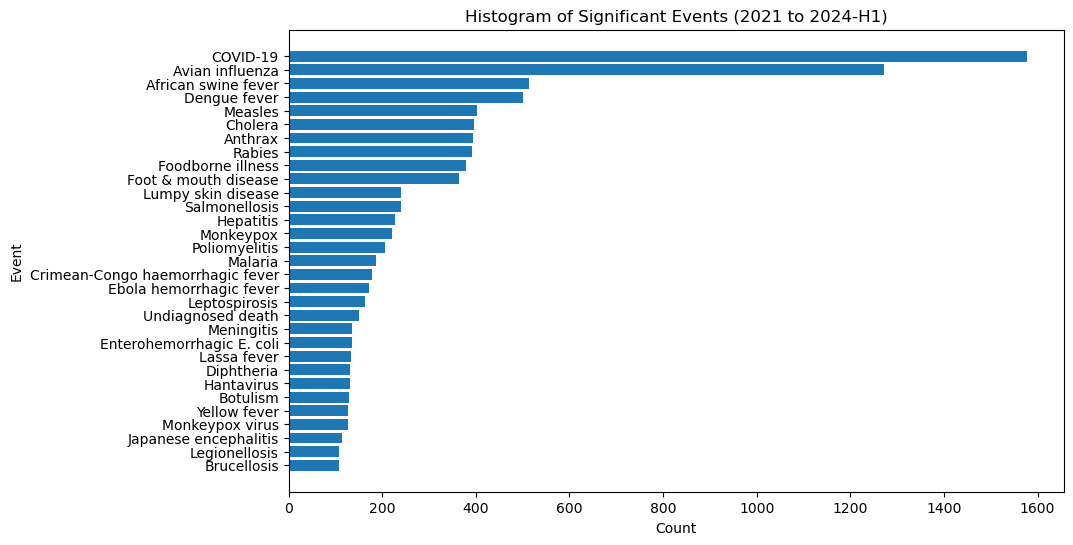

In [325]:
import matplotlib.pyplot as plt

# Filter to show only important events with a count greater than a threshold, e.g., 100
threshold = 100
df_significant_events = df_event_count_1[df_event_count_1['Count'] > threshold]

# Sort by Count to display the most significant events first
df_significant_events = df_significant_events.sort_values(by='Count', ascending=False)

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.barh(df_significant_events['Event'], df_significant_events['Count'])
plt.xlabel('Count')
plt.ylabel('Event')
plt.title('Histogram of Significant Events (2021 to 2024-H1)')
plt.gca().invert_yaxis()  # Invert y-axis to have the largest counts at the top
plt.show()

In [43]:
sum(df_significant_events['Count'].tolist())

9548

In [44]:
#df_year_2021_2024[df_year_2021_2024['event_type']=='Antimicrobial stewardship']

#### extract countries

In [46]:
def string_list_to_list(string_list):
    try:
        # Convert the string representation of list to an actual list
        lst = ast.literal_eval(string_list)
        # Perform the replacement
        new_lst = [dict["1"] for dict in lst]
        
        return new_lst
    except (ValueError, SyntaxError):
        # In case of an error, return the original string
        return string_list

def get_country(lst):
    new_list = [item.split(',')[-1].strip() for item in lst]
    new_list = set(new_list)
    new_list = list(new_list)
    return new_list


# 定义转换函数
def convert_to_list(s):
    try:
        return ast.literal_eval(s)
    except (ValueError, SyntaxError):
        return s

In [47]:
# df_year_2021_2024_filtered['country_orig']

In [48]:
df_year_2021_2024_filtered.loc[:, 'region_list'] = df_year_2021_2024_filtered['country_orig'].apply(string_list_to_list)

C:\Users\ywy14\AppData\Local\Temp\ipykernel_11304\164225946.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_year_2021_2024_filtered.loc[:, 'region_list'] = df_year_2021_2024_filtered['country_orig'].apply(string_list_to_list)


In [49]:
df_year_2021_2024_filtered['region_list']

0                                               [Thailand]
1                                                  [China]
2                                       [China, Hong Kong]
3                                                [Turkiye]
4                                                  [India]
                               ...                        
16251                                             [Africa]
16252    [Afghanistan, Pakistan, India, Sri Lanka, Bang...
16253                              [Canada, United States]
16254                             [Telangana State, India]
16255                      [Hadhramaut Governorate, Yemen]
Name: region_list, Length: 13867, dtype: object

In [50]:
df_year_2021_2024_filtered.loc[:, 'country_list'] = df_year_2021_2024_filtered['region_list'].apply(get_country)

C:\Users\ywy14\AppData\Local\Temp\ipykernel_11304\165344506.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_year_2021_2024_filtered.loc[:, 'country_list'] = df_year_2021_2024_filtered['region_list'].apply(get_country)


In [51]:
df_year_2021_2024_filtered['country_list']

0                                               [Thailand]
1                                                  [China]
2                                       [Hong Kong, China]
3                                                [Turkiye]
4                                                  [India]
                               ...                        
16251                                             [Africa]
16252    [India, Bangladesh, Sri Lanka, Afghanistan, Pa...
16253                              [United States, Canada]
16254                                              [India]
16255                                              [Yemen]
Name: country_list, Length: 13867, dtype: object

In [52]:
# df_year_2021_2024_filtered

In [53]:
df_year_2021_2024_filtered.loc[:, 'country_list']=df_year_2021_2024_filtered['country_list'].apply(convert_to_list)

In [54]:
df_year_2021_2024_filtered['country_list']

0                                               [Thailand]
1                                                  [China]
2                                       [Hong Kong, China]
3                                                [Turkiye]
4                                                  [India]
                               ...                        
16251                                             [Africa]
16252    [India, Bangladesh, Sri Lanka, Afghanistan, Pa...
16253                              [United States, Canada]
16254                                              [India]
16255                                              [Yemen]
Name: country_list, Length: 13867, dtype: object

In [55]:
from collections import Counter, defaultdict
def country_count(column):
    country_counter = Counter([i for item in column for i in item])
    return pd.DataFrame(country_counter.items(), columns=['Country', 'Count'])

In [56]:
df_country_count = country_count(df_year_2021_2024_filtered['country_list']).sort_values(by='Count', ascending=False)
df_country_count

,Country,Count
9,United States,1864
4,India,1522
28,Worldwide,970
29,Nigeria,592
32,Bangladesh,358
...,...,...
235,Scotland,1
236,Bermuda [UK],1
237,Latin America,1
48,Castilla y Leon,1


In [57]:
# a = df_country_count['Country'].tolist()

In [58]:
# sorted(a)

In [59]:
country_mapping = {
    'USA': 'United States',
    'United States of America': 'United States',
    'UK': 'United Kingdom',
    'The Netherlands': 'Netherlands',
    'Congo [DRC]': 'Democratic Republic of the Congo',
    'Congo [Republic]': 'Republic of the Congo',
    'Myanmar [Burma]': 'Myanmar',
    'Northern Ireland': 'United Kingdom',
    'England': 'United Kingdom',
    'Taiwan 907': 'Taiwan',
    'Hong Kong': 'China',
    'Ivory Coast': "Cote d'Ivoire",
    'Republic of Macedonia (FYROM)': 'North Macedonia',
    'Macedonia (FYROM)': 'North Macedonia',
    'East Timor': 'Timor-Leste',
    'Timor Leste': 'Timor-Leste',
    'Faroe Islands': 'Denmark',
    'Macau': 'China',
    'Palestinian Authority': 'Palestine',
    'Greenland [Denmark]': 'Denmark',
    'Reunion': 'France',
    'French Guiana': 'France',
    'Martinique': 'France',
    'Guadeloupe': 'France',
    'American Samoa [USA]': 'American Samoa',
    'Bermuda [UK]': 'United Kingdom',
    'Gibraltar [UK]': 'United Kingdom',
    'Cayman Islands [UK]': 'United Kingdom',
    'Saint Martin [France/Netherlands]': 'France',
    'Saint Martin [France/Netherlands]': 'Netherlands',
    # Add more mappings as needed
}

In [60]:
df_country_count['Country'] = df_country_count['Country'].replace(country_mapping)

# Group by the standardized country names and sum the counts
df_country_count = df_country_count.groupby('Country', as_index=False)['Count'].sum()

# Display the resulting DataFrame
df_country_count.sort_values(by='Count', ascending=False, inplace=True)
df_country_count.reset_index(drop=True, inplace=True)
df_country_count

,Country,Count
0,United States,1868
1,India,1522
2,Worldwide,970
3,Nigeria,592
4,China,428
...,...,...
236,New England,1
237,Massachusetts,1
238,The Bahamas,1
239,The Gambia,1


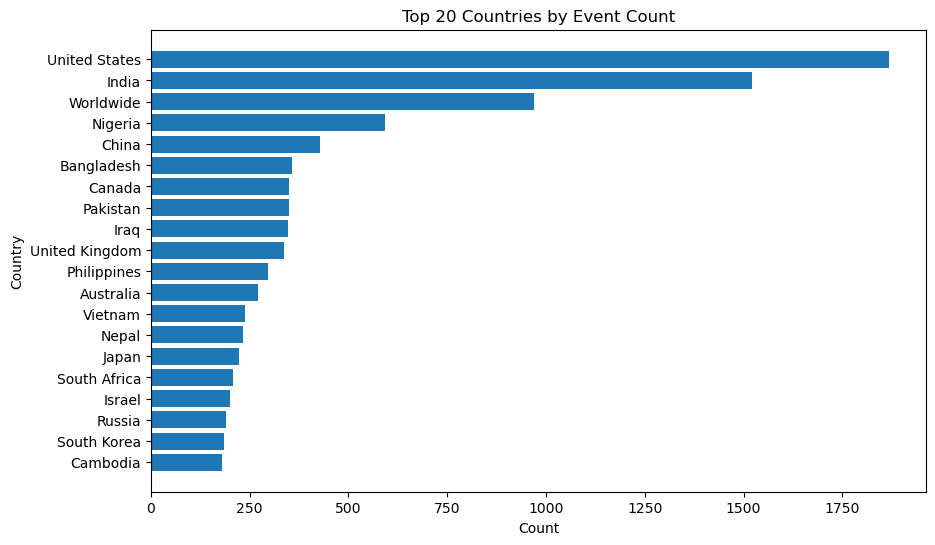

In [61]:
top_n = 20
df_top_countries = df_country_count.sort_values(by='Count', ascending=False).head(top_n)

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.barh(df_top_countries['Country'], df_top_countries['Count'])
plt.xlabel('Count')
plt.ylabel('Country')
plt.title(f'Top {top_n} Countries by Event Count')
plt.gca().invert_yaxis()  # Invert y-axis to have the largest counts at the top
plt.show()

### By year and seasons

In [63]:
# Define the cutoff date
end_date = datetime(2021, 12, 31)

# Calculate the start date (one year before the cutoff date)
start_date = datetime(2021, 1, 1)

# Filter the DataFrame
df_year_2021 = df_year_2021_2024_filtered[(df_year_2021_2024['date_published'] >= start_date) & (df_year_2021_2024['date_published'] <= end_date)]

C:\Users\ywy14\AppData\Local\Temp\ipykernel_11304\2078575023.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_year_2021 = df_year_2021_2024_filtered[(df_year_2021_2024['date_published'] >= start_date) & (df_year_2021_2024['date_published'] <= end_date)]


In [64]:
df_event_count_2021 = event_count(df_year_2021['event_type']).sort_values(by='Count', ascending=False)

In [65]:
df_event_count_2021

,Event,Count
4,COVID-19,1047
7,Avian influenza,377
28,African swine fever,147
26,Dengue fever,115
49,Cholera,100
...,...,...
101,Blastomycosis,1
249,Chemical exposure,1
250,Canine enteric coronavirus,1
251,Varroosis,1


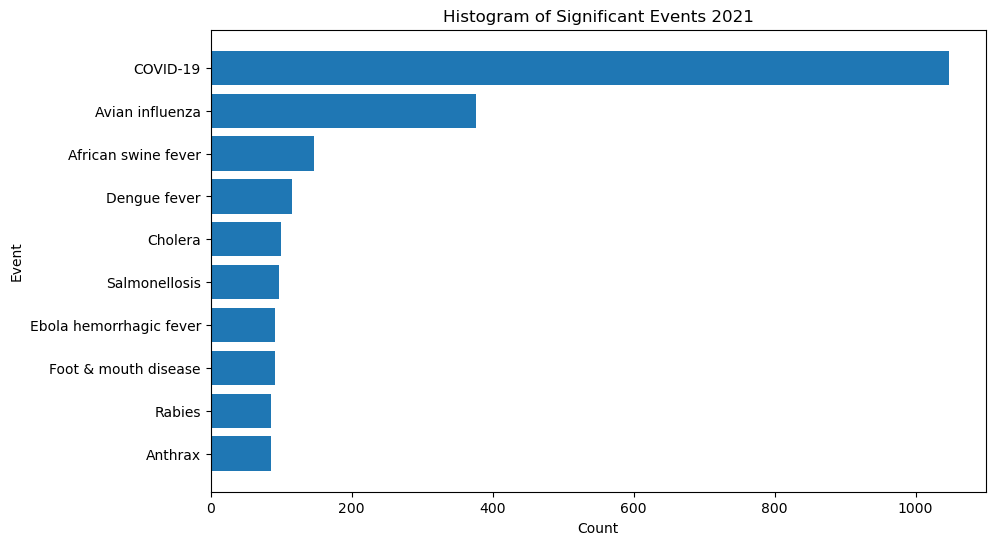

In [66]:
# Filter to show only important events with a count greater than a threshold, e.g., 100
# threshold = 50
# df_significant_events_2021 = df_event_count_2021[df_event_count_2021['Count'] > threshold]

# # Sort by Count to display the most significant events first
# df_significant_events_2021 = df_significant_events_2021.sort_values(by='Count', ascending=False)

# # Plot the histogram
# plt.figure(figsize=(10, 6))
# plt.barh(df_significant_events_2021['Event'], df_significant_events_2021['Count'])
# plt.xlabel('Count')
# plt.ylabel('Event')
# plt.title('Histogram of Significant Events 2021')
# plt.gca().invert_yaxis()  # Invert y-axis to have the largest counts at the top
# plt.show()

top_n = 10
df_significant_events_2021 = df_event_count_2021.sort_values(by='Count', ascending=False).head(top_n)

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.barh(df_significant_events_2021['Event'], df_significant_events_2021['Count'])
plt.xlabel('Count')
plt.ylabel('Event')
plt.title('Histogram of Significant Events 2021')
plt.gca().invert_yaxis()  # Invert y-axis to have the largest counts at the top
plt.show()

In [67]:
# Define the cutoff date
end_date = datetime(2022, 12, 31)

# Calculate the start date (one year before the cutoff date)
start_date = datetime(2022, 1, 1)

# Filter the DataFrame
df_year_2022 = df_year_2021_2024_filtered[(df_year_2021_2024['date_published'] >= start_date) & (df_year_2021_2024['date_published'] <= end_date)]

C:\Users\ywy14\AppData\Local\Temp\ipykernel_11304\872592190.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_year_2022 = df_year_2021_2024_filtered[(df_year_2021_2024['date_published'] >= start_date) & (df_year_2021_2024['date_published'] <= end_date)]


In [68]:
df_event_count_2022 = event_count(df_year_2022['event_type']).sort_values(by='Count', ascending=False)

In [69]:
df_event_count_2022

,Event,Count
3,COVID-19,406
5,Avian influenza,389
108,Monkeypox,196
25,African swine fever,144
10,Dengue fever,130
...,...,...
241,Sorghum toxicity,1
243,Tomato chlorosis virus,1
244,Blight & wilt,1
246,Heat exhaustion,1


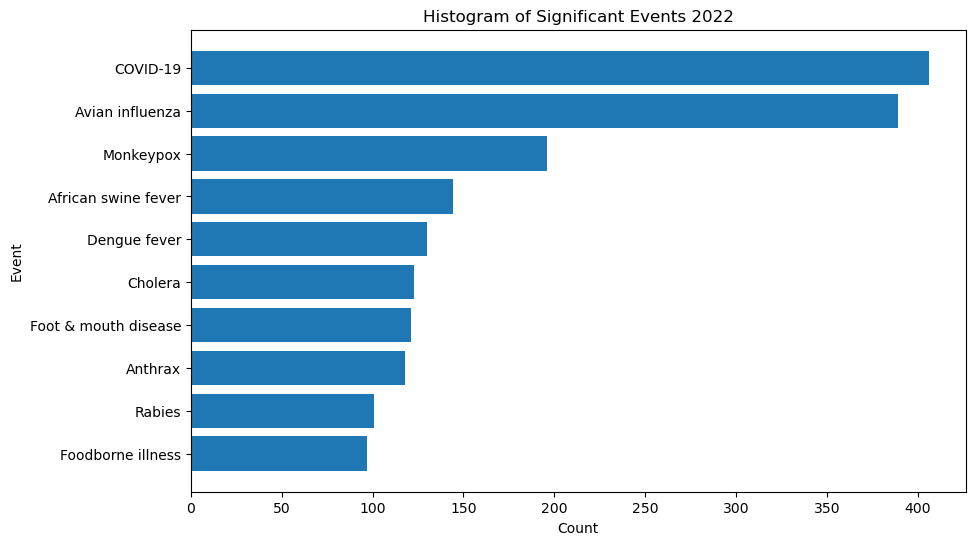

In [70]:
top_n = 10
df_significant_events_2022 = df_event_count_2022.sort_values(by='Count', ascending=False).head(top_n)

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.barh(df_significant_events_2022['Event'], df_significant_events_2022['Count'])
plt.xlabel('Count')
plt.ylabel('Event')
plt.title('Histogram of Significant Events 2022')
plt.gca().invert_yaxis()  # Invert y-axis to have the largest counts at the top
plt.show()

In [71]:
# Define the cutoff date
end_date = datetime(2023, 12, 31)

# Calculate the start date (one year before the cutoff date)
start_date = datetime(2023, 1, 1)

# Filter the DataFrame
df_year_2023 = df_year_2021_2024_filtered[(df_year_2021_2024['date_published'] >= start_date) & (df_year_2021_2024['date_published'] <= end_date)]

C:\Users\ywy14\AppData\Local\Temp\ipykernel_11304\3273454195.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_year_2023 = df_year_2021_2024_filtered[(df_year_2021_2024['date_published'] >= start_date) & (df_year_2021_2024['date_published'] <= end_date)]


In [72]:
df_year_2023 = event_count(df_year_2023['event_type']).sort_values(by='Count', ascending=False)

In [73]:
df_year_2023

,Event,Count
2,Avian influenza,326
34,Dengue fever,173
11,Anthrax,155
52,African swine fever,145
25,Measles,141
...,...,...
242,Brown streak,1
243,Sporotrichosis,1
246,Wheat streak mosaic disease,1
249,Avian metapneumovirus,1


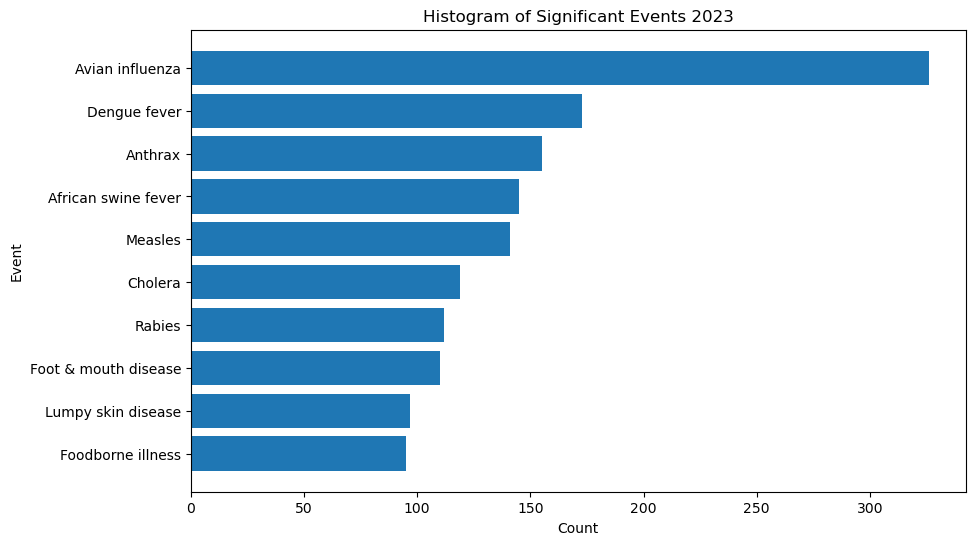

In [74]:
top_n = 10
df_significant_events_2023 = df_year_2023.sort_values(by='Count', ascending=False).head(top_n)

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.barh(df_significant_events_2023['Event'], df_significant_events_2023['Count'])
plt.xlabel('Count')
plt.ylabel('Event')
plt.title('Histogram of Significant Events 2023')
plt.gca().invert_yaxis()  # Invert y-axis to have the largest counts at the top
plt.show()

In [75]:
# Define the cutoff date
end_date = datetime(2024, 7, 1)

# Calculate the start date (one year before the cutoff date)
start_date = datetime(2024, 1, 1)

# Filter the DataFrame
df_year_2024 = df_year_2021_2024_filtered[(df_year_2021_2024['date_published'] >= start_date) & (df_year_2021_2024['date_published'] <= end_date)]

C:\Users\ywy14\AppData\Local\Temp\ipykernel_11304\3648631392.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_year_2024 = df_year_2021_2024_filtered[(df_year_2021_2024['date_published'] >= start_date) & (df_year_2021_2024['date_published'] <= end_date)]


In [76]:
df_year_2024 = event_count(df_year_2024['event_type']).sort_values(by='Count', ascending=False)

In [77]:
df_year_2024

,Event,Count
1,Avian influenza,178
26,Measles,128
33,Foodborne illness,112
18,Rabies,94
20,Dengue fever,81
...,...,...
118,Pentastomiasis,1
113,Potato spindle tuber viroid,1
112,Superficial epidermolytic ichthyosis,1
111,Porcine reprod. & resp. syndrome,1


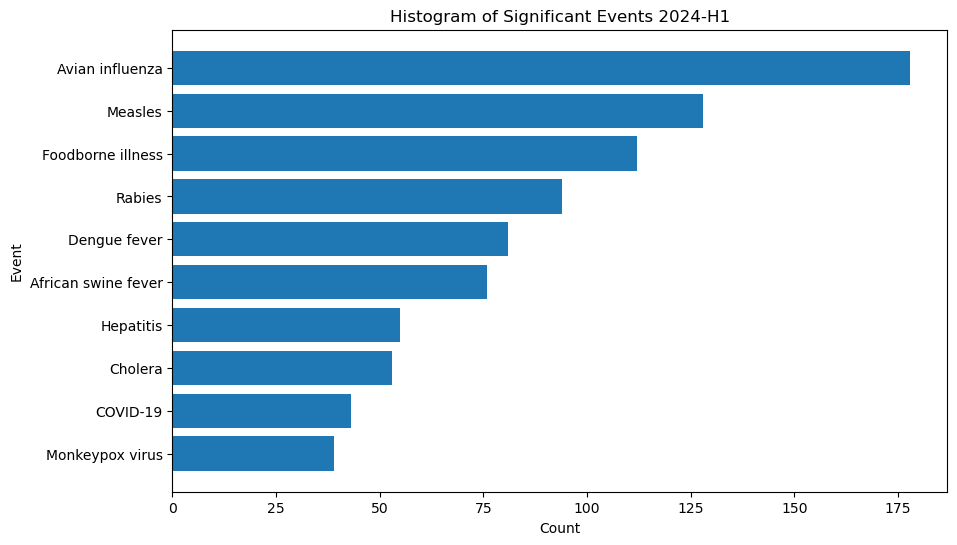

In [78]:
top_n = 10
df_significant_events_2024 = df_year_2024.sort_values(by='Count', ascending=False).head(top_n)

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.barh(df_significant_events_2024['Event'], df_significant_events_2024['Count'])
plt.xlabel('Count')
plt.ylabel('Event')
plt.title('Histogram of Significant Events 2024-H1')
plt.gca().invert_yaxis()  # Invert y-axis to have the largest counts at the top
plt.show()

In [79]:
df_year_2021_2024_filtered['Half_Year'] = df_year_2021_2024_filtered['date_published'].apply(
    lambda x: f"{x.year}-H1" if x.month <= 6 else f"{x.year}-H2"
)

# Step 2: Define the event_count function
def event_count(column):
    event_counter = Counter([item for item in column])
    return pd.DataFrame(event_counter.items(), columns=['Event', 'Count'])

# Step 3: Group by Half_Year and Event, then apply event_count
# First, group the dataframe by Half_Year, and then apply the event_count function on 'event_type'
df_half_year_counts = (
    df_year_2021_2024_filtered
    .groupby('Half_Year')['event_type']
    .apply(event_count)
    .reset_index(level=1, drop=True)
    .reset_index()
)

C:\Users\ywy14\AppData\Local\Temp\ipykernel_11304\388003346.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_year_2021_2024_filtered['Half_Year'] = df_year_2021_2024_filtered['date_published'].apply(


In [80]:
df_half_year_counts.columns = ['Half_Year', 'Event', 'Count']

# Sort by Half_Year and Event for a clearer view
df_half_year_counts.sort_values(by=['Half_Year', 'Count'], ascending=[True, False], inplace=True)
df_half_year_counts

,Half_Year,Event,Count
3,2021-H1,COVID-19,526
13,2021-H1,Avian influenza,204
6,2021-H1,African swine fever,69
18,2021-H1,Ebola hemorrhagic fever,59
1,2021-H1,Rabies,43
...,...,...,...
1832,2024-H1,Pepper ringspot virus,1
1833,2024-H1,Oropouche and Mayaro viruses,1
1834,2024-H1,Streptococcus suis,1
1835,2024-H1,Foodborne Illness,1


In [81]:
df_half_year_counts.to_csv("df_half_year_counts.csv", index=False,encoding='utf-8-sig')

In [82]:
# Calculate the difference in counts between consecutive half-years for each event
df_half_year_counts['Previous_Count'] = df_half_year_counts.groupby('Event')['Count'].shift(1)
df_half_year_counts['Change'] = df_half_year_counts['Count'] - df_half_year_counts['Previous_Count']

# Filter for events showing an increase in the latest half-year period
increasing_trend_events = df_half_year_counts[df_half_year_counts['Change'] > 10]

In [83]:
increasing_trend_events

,Half_Year,Event,Count,Previous_Count,Change
291,2021-H2,Dengue fever,74,41.0,33.0
267,2021-H2,Anthrax,70,16.0,54.0
313,2021-H2,Cholera,67,33.0,34.0
270,2021-H2,Salmonellosis,60,37.0,23.0
264,2021-H2,Foot & mouth disease,56,38.0,18.0
...,...,...,...,...,...
1618,2024-H1,Undiagnosed death,27,12.0,15.0
1671,2024-H1,Lassa fever,23,7.0,16.0
1695,2024-H1,Kyasanur Forest disease,21,1.0,20.0
1748,2024-H1,Western equine encephalitis,21,7.0,14.0


In [84]:
high_frequency_events = df_half_year_counts[df_half_year_counts['Count'] > 100]
high_frequency_events

,Half_Year,Event,Count,Previous_Count,Change
3,2021-H1,COVID-19,526,NaN,NaN
13,2021-H1,Avian influenza,204,NaN,NaN
273,2021-H2,COVID-19,521,526.0,-5.0
263,2021-H2,Avian influenza,174,204.0,-30.0
540,2022-H1,COVID-19,288,521.0,-233.0
531,2022-H1,Avian influenza,236,174.0,62.0
795,2022-H2,Avian influenza,155,236.0,-81.0
905,2022-H2,Monkeypox,135,61.0,74.0
800,2022-H2,COVID-19,120,288.0,-168.0
1076,2023-H1,Avian influenza,176,155.0,21.0


In [85]:
# # Count the number of half-year periods each event appears in
# event_period_counts = df_half_year_counts.groupby('Event')['Half_Year'].nunique().reset_index(name='Periods')

# # Filter for events with a low period count but high event count
# sporadic_significant_events = event_period_counts[event_period_counts['Periods'] <= 2]
# sporadic_significant_events = sporadic_significant_events.merge(df_half_year_counts, on='Event')
# sporadic_significant_events = sporadic_significant_events[sporadic_significant_events['Count'] > 50]
# sporadic_significant_events

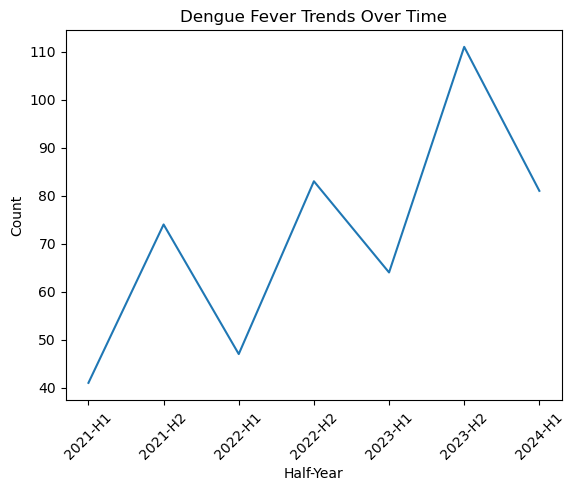

In [86]:
event_trends = df_half_year_counts[df_half_year_counts['Event'] == 'Dengue fever']
plt.plot(event_trends['Half_Year'], event_trends['Count'])
plt.xlabel('Half-Year')
plt.ylabel('Count')
plt.title('Dengue Fever Trends Over Time')
plt.xticks(rotation=45)
plt.show()

In [87]:
# Define a function to map months to seasons
def get_season(date):
    if date.month in [1, 2, 3]:
        return f"{date.year}-Winter"
    elif date.month in [4, 5, 6]:
        return f"{date.year}-Spring"
    elif date.month in [7, 8, 9]:
        return f"{date.year}-Summer"
    else:
        return f"{date.year}-Autumn"

# Apply the get_season function to create a 'Season' column
df_year_2021_2024_filtered['Season'] = df_year_2021_2024_filtered['date_published'].apply(get_season)

# Define the event_count function
def event_count(column):
    event_counter = Counter([item for item in column])
    return pd.DataFrame(event_counter.items(), columns=['Event', 'Count'])

# Group by Season and Event, then apply event_count
df_season_counts = (
    df_year_2021_2024_filtered
    .groupby('Season')['event_type']
    .apply(event_count)
    .reset_index(level=1, drop=True)
    .reset_index()
)

# Rename columns for clarity
df_season_counts.columns = ['Season', 'Event', 'Count']

# Sort by Season and Event for a clearer view
df_season_counts.sort_values(by=['Season', 'Count'], ascending=[True, False], inplace=True)
df_season_counts

C:\Users\ywy14\AppData\Local\Temp\ipykernel_11304\4172269284.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_year_2021_2024_filtered['Season'] = df_year_2021_2024_filtered['date_published'].apply(get_season)


,Season,Event,Count
10,2021-Autumn,COVID-19,264
0,2021-Autumn,Avian influenza,118
30,2021-Autumn,African swine fever,41
28,2021-Autumn,Dengue fever,37
1,2021-Autumn,Foot & mouth disease,29
...,...,...,...
2450,2024-Winter,Streptococcus suis,1
2451,2024-Winter,Japanese encephalitis,1
2452,2024-Winter,Foodborne Illness,1
2453,2024-Winter,Argentine hemorrhagic fever,1


In [88]:
# Find top events for each season
df_top_events_per_season = df_season_counts.groupby('Season').apply(lambda x: x.nlargest(5, 'Count')).reset_index(drop=True)
df_top_events_per_season

,Season,Event,Count
0,2021-Autumn,COVID-19,264
1,2021-Autumn,Avian influenza,118
2,2021-Autumn,African swine fever,41
3,2021-Autumn,Dengue fever,37
4,2021-Autumn,Foot & mouth disease,29
...,...,...,...
65,2024-Winter,Measles,101
66,2024-Winter,Avian influenza,92
67,2024-Winter,Rabies,55
68,2024-Winter,Foodborne illness,47


In [89]:
# Sum counts for each event across all seasons
df_total_event_counts = df_season_counts.groupby('Event')['Count'].sum().reset_index()
df_total_event_counts.sort_values(by='Count', ascending=False, inplace=True)
df_total_event_counts

,Event,Count
111,COVID-19,1577
52,Avian influenza,1273
17,African swine fever,513
206,Dengue fever,501
429,Measles,403
...,...,...
365,Insecticide resistance,1
369,Iris yellow spot virus,1
372,Jingmen virus,1
374,Karshi virus,1


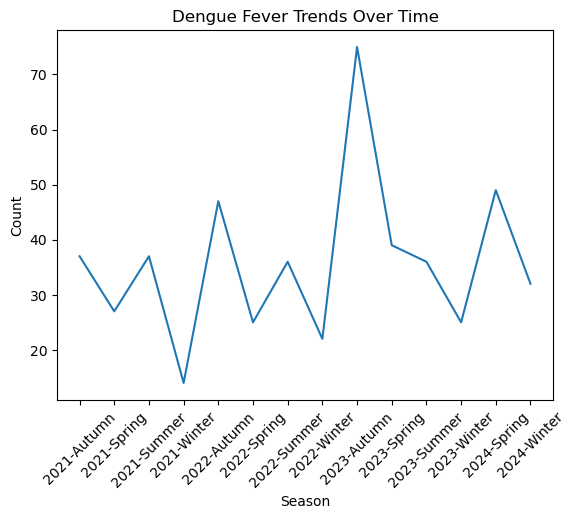

In [90]:
# Filter data for a specific event, e.g., "Dengue fever"
event_trend = df_season_counts[df_season_counts['Event'] == 'Dengue fever']
plt.plot(event_trend['Season'], event_trend['Count'])
plt.xlabel('Season')
plt.ylabel('Count')
plt.title('Dengue Fever Trends Over Time')
plt.xticks(rotation=45)
plt.show()

In [91]:
# Filter for events with significant counts in just one or two specific seasons
rare_seasonal_events = df_season_counts[df_season_counts['Count'] > 10].groupby('Event').filter(lambda x: x['Season'].nunique() <= 2)
rare_seasonal_events

,Season,Event,Count
3,2021-Autumn,Yellow fever,26
207,2021-Spring,Rabbit hemorrhagic disease,13
388,2021-Summer,Plague,21
410,2021-Summer,Vector borne diseases,17
376,2021-Summer,Bluetongue,16
394,2021-Summer,Invasive mosquito,11
554,2021-Winter,Alcohol poisoning,13
709,2022-Autumn,Streptococcus,13
726,2022-Autumn,Vector borne diseases,12
922,2022-Spring,Diarrhea,11


In [92]:
# Pivot table to compare event counts by season
df_season_pivot = df_season_counts.pivot(index='Event', columns='Season', values='Count').fillna(0)
df_season_pivot

Season,2021-Autumn,2021-Spring,2021-Summer,2021-Winter,2022-Autumn,2022-Spring,2022-Summer,2022-Winter,2023-Autumn,2023-Spring,2023-Summer,2023-Winter,2024-Spring,2024-Winter
Event,,,,,,,,,,,,,,
Abalone viral ganglioneuritis,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Abortive zoonotic diseases,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Abrus precatorius,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Acanthamoeba,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
Acidovorax citrulli blotch,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zika virus,7.0,2.0,5.0,1.0,2.0,0.0,3.0,1.0,11.0,1.0,4.0,2.0,2.0,4.0
Zoonoses,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Zoonosis,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [93]:
dengue_fever_row = df_season_pivot.loc['Dengue fever']
dengue_fever_row

Season
2021-Autumn    37.0
2021-Spring    27.0
2021-Summer    37.0
2021-Winter    14.0
2022-Autumn    47.0
2022-Spring    25.0
2022-Summer    36.0
2022-Winter    22.0
2023-Autumn    75.0
2023-Spring    39.0
2023-Summer    36.0
2023-Winter    25.0
2024-Spring    49.0
2024-Winter    32.0
Name: Dengue fever, dtype: float64

In [94]:
# Aggregate counts by year-season combinations for longitudinal trends
df_season_counts['Year'] = df_season_counts['Season'].str[:4]
df_longitudinal_trends = df_season_counts.groupby(['Event', 'Year'])['Count'].sum().unstack().fillna(0)
df_longitudinal_trends

Year,2021,2022,2023,2024
Event,,,,
Abalone viral ganglioneuritis,1.0,0.0,0.0,0.0
Abortive zoonotic diseases,0.0,0.0,1.0,0.0
Abrus precatorius,0.0,1.0,0.0,0.0
Acanthamoeba,0.0,0.0,0.0,1.0
Acidovorax citrulli blotch,1.0,0.0,0.0,0.0
...,...,...,...,...
Zika virus,15.0,6.0,18.0,6.0
Zoonoses,0.0,1.0,1.0,0.0
Zoonosis,0.0,0.0,0.0,1.0


In [95]:
# Calculate a rolling mean for each event and flag spikes
df_season_counts['Rolling_Mean'] = df_season_counts.groupby('Event')['Count'].transform(lambda x: x.rolling(4, 1).mean())
df_season_counts['Spike'] = df_season_counts['Count'] > (df_season_counts['Rolling_Mean'] * 1.5)
significant_spikes = df_season_counts[df_season_counts['Spike']]

In [96]:
significant_spikes

,Season,Event,Count,Year,Rolling_Mean,Spike
172,2021-Spring,Lumpy skin disease,24,2021,15.50,True
179,2021-Spring,Crimean-Congo haemorrhagic fever,11,2021,6.00,True
216,2021-Spring,Mucormycosis,10,2021,5.50,True
227,2021-Spring,Undiagnosed die-off,5,2021,3.00,True
270,2021-Spring,Undiagnosed disease,4,2021,2.50,True
...,...,...,...,...,...,...
2342,2024-Winter,Pneumonia,4,2024,2.00,True
2322,2024-Winter,Invasive mosquito,3,2024,1.75,True
2357,2024-Winter,Psittacosis,3,2024,1.50,True
2386,2024-Winter,Respiratory syncytial virus,3,2024,1.75,True


In [97]:
# Assuming df_season_counts has columns ['Season', 'Event', 'Count']

# Step 1: Calculate average historical counts for each event
# Calculate Total_Count
total_counts = df_season_counts.groupby('Event')['Count'].sum().reset_index(name='Total_Count')

# Calculate Average_Count
average_counts = df_season_counts.groupby('Event')['Count'].mean().reset_index(name='Average_Count')

# Merge the two DataFrames on the 'Event' column
average_counts = total_counts.merge(average_counts, on='Event')


# Step 2: Get recent data, e.g., from the last two seasons, and calculate change
recent_data = df_season_counts[df_season_counts['Season'].isin(['2023-Summer','2023-Autumn','2024-Winter','2024-Spring'])]
#recent_data = df_season_counts[df_season_counts['Season'].isin(['2024-Spring'])]
# recent_counts = recent_data.groupby('Event')['Count'].sum().reset_index(name='Recent_Count')
recent_counts = recent_data.groupby('Event')['Count'].mean().reset_index(name='Recent_Count')

# Calculate percentage increase or absolute increase over historical average
trending_diseases = average_counts.merge(recent_counts, on='Event')
trending_diseases['Change'] = trending_diseases['Recent_Count'] - trending_diseases['Average_Count']
trending_diseases['Percentage_Change'] = (trending_diseases['Change'] / trending_diseases['Average_Count']) * 100

# Step 3: Select top 5 based on recent increase or high counts
# Sort by both Change and Percentage_Change
top_diseases = trending_diseases.sort_values(by=['Change', 'Percentage_Change'], ascending=False).head(10)

# Step 4: Output analysis for top 5 diseases
for i, row in top_diseases.iterrows():
    event = row['Event']
    avg_count = row['Average_Count']
    recent_count = row['Recent_Count']
    change = row['Change']
    perc_change = row['Percentage_Change']
    
    print(f"Event: {event}")
    print(f" - Average Historical Count: {avg_count:.2f}")
    print(f" - Recent Count (Last Two Seasons): {recent_count}")
    print(f" - Change from Historical Average: {change:.2f} ({perc_change:.2f}%)")
    print(" - Significance: This disease is worth noticing due to", end=" ")
    
    # Custom explanation based on criteria
    if recent_count > avg_count and perc_change > 50:
        print("a significant recent increase, suggesting a potential outbreak.")
    elif recent_count > avg_count and perc_change < 50:
        print("a steady increase, indicating a consistent presence that may grow.")
    elif avg_count > recent_count:
        print("a historically high count, even if recent counts are stable.")
    print("\n")

Event: Measles
 - Average Historical Count: 28.79
 - Recent Count (Last Two Seasons): 45.5
 - Change from Historical Average: 16.71 (58.06%)
 - Significance: This disease is worth noticing due to a significant recent increase, suggesting a potential outbreak.


Event: Foodborne illness
 - Average Historical Count: 27.07
 - Recent Count (Last Two Seasons): 40.25
 - Change from Historical Average: 13.18 (48.68%)
 - Significance: This disease is worth noticing due to a steady increase, indicating a consistent presence that may grow.


Event: Dengue fever
 - Average Historical Count: 35.79
 - Recent Count (Last Two Seasons): 48.0
 - Change from Historical Average: 12.21 (34.13%)
 - Significance: This disease is worth noticing due to a steady increase, indicating a consistent presence that may grow.


Event: Rabies
 - Average Historical Count: 28.00
 - Recent Count (Last Two Seasons): 37.5
 - Change from Historical Average: 9.50 (33.93%)
 - Significance: This disease is worth noticing due t

In [98]:
# average_counts.sort_values(by=['Total_Count'], ascending=False).head(10)

In [99]:
# recent_counts.sort_values(by=['Recent_Count'], ascending=False)

In [100]:
# trending_diseases.sort_values(by=['Average_Count'], ascending=False).head(50)

In [101]:
ShownResult = trending_diseases.sort_values(by=['Average_Count'], ascending=False).head(10)
ShownResultnew = ShownResult.rename(columns={'Average_Count': 'Average_Count(seasonal)'})
ShownResultnew

,Event,Total_Count,Average_Count(seasonal),Recent_Count,Change,Percentage_Change
42,COVID-19,1577,112.642857,17.50,-95.142857,-84.464172
20,Avian influenza,1273,90.928571,82.00,-8.928571,-9.819324
4,African swine fever,513,36.642857,36.50,-0.142857,-0.389864
82,Dengue fever,501,35.785714,48.00,12.214286,34.131737
180,Measles,403,28.785714,45.50,16.714286,58.064516
57,Cholera,396,28.285714,29.75,1.464286,5.176768
15,Anthrax,394,28.142857,30.75,2.607143,9.263959
248,Rabies,392,28.000000,37.50,9.500000,33.928571
115,Foodborne illness,379,27.071429,40.25,13.178571,48.680739
116,Foot & mouth disease,363,25.928571,14.00,-11.928571,-46.005510


In [102]:
ShownResult = trending_diseases.sort_values(by=['Change'], ascending=False).head(10)
ShownResultnew = ShownResult.rename(columns={'Average_Count': 'Average_Count(seasonal)'})
ShownResultnew

,Event,Total_Count,Average_Count(seasonal),Recent_Count,Change,Percentage_Change
180,Measles,403,28.785714,45.500000,16.714286,58.064516
115,Foodborne illness,379,27.071429,40.250000,13.178571,48.680739
82,Dengue fever,501,35.785714,48.000000,12.214286,34.131737
248,Rabies,392,28.000000,37.500000,9.500000,33.928571
73,Crimean-Congo haemorrhagic fever,178,13.692308,22.333333,8.641026,63.108614
85,Diphtheria,132,9.428571,17.250000,7.821429,82.954545
173,Lumpy skin disease,241,17.214286,24.250000,7.035714,40.871369
139,Hepatitis,228,16.285714,21.750000,5.464286,33.552632
339,West Nile virus,93,6.642857,12.000000,5.357143,80.645161
164,Legionellosis,107,8.230769,13.333333,5.102564,61.993769


In [103]:
ShownResult = trending_diseases.sort_values(by=['Percentage_Change'], ascending=False).head(10)
ShownResultnew = ShownResult.rename(columns={'Average_Count': 'Average_Count(seasonal)'})
ShownResultnew

,Event,Total_Count,Average_Count(seasonal),Recent_Count,Change,Percentage_Change
9,Amebic meningoencephalitis,22,2.750000,7.000000,4.250000,154.545455
79,Cyclosporiasis,12,3.000000,7.000000,4.000000,133.333333
158,Kyasanur Forest disease,31,3.875000,7.333333,3.458333,89.247312
311,Trichinellosis,24,2.666667,5.000000,2.333333,87.500000
85,Diphtheria,132,9.428571,17.250000,7.821429,82.954545
339,West Nile virus,93,6.642857,12.000000,5.357143,80.645161
211,Oropouche virus,15,3.750000,6.500000,2.750000,73.333333
300,Tick-borne encephalitis,39,3.250000,5.500000,2.250000,69.230769
73,Crimean-Congo haemorrhagic fever,178,13.692308,22.333333,8.641026,63.108614
164,Legionellosis,107,8.230769,13.333333,5.102564,61.993769


In [104]:
ShownResult = trending_diseases.sort_values(by=['Recent_Count'], ascending=False).head(10)
ShownResultnew = ShownResult.rename(columns={'Average_Count': 'Average_Count(seasonal)'})
ShownResultnew

,Event,Total_Count,Average_Count(seasonal),Recent_Count,Change,Percentage_Change
20,Avian influenza,1273,90.928571,82.000000,-8.928571,-9.819324
82,Dengue fever,501,35.785714,48.000000,12.214286,34.131737
180,Measles,403,28.785714,45.500000,16.714286,58.064516
115,Foodborne illness,379,27.071429,40.250000,13.178571,48.680739
248,Rabies,392,28.000000,37.500000,9.500000,33.928571
4,African swine fever,513,36.642857,36.500000,-0.142857,-0.389864
15,Anthrax,394,28.142857,30.750000,2.607143,9.263959
57,Cholera,396,28.285714,29.750000,1.464286,5.176768
173,Lumpy skin disease,241,17.214286,24.250000,7.035714,40.871369
73,Crimean-Congo haemorrhagic fever,178,13.692308,22.333333,8.641026,63.108614


### Recently high event count disease with recent increase

In [280]:
Recent_Count = trending_diseases[trending_diseases['Change'] > 0].sort_values(by=['Recent_Count'], ascending=False).head(10)
ShownResultnew = Recent_Count.rename(columns={'Average_Count': 'Average_Count(seasonal)'})
ShownResultnew

,Event,Total_Count,Average_Count(seasonal),Recent_Count,Change,Percentage_Change
82,Dengue fever,501,35.785714,48.000000,12.214286,34.131737
180,Measles,403,28.785714,45.500000,16.714286,58.064516
115,Foodborne illness,379,27.071429,40.250000,13.178571,48.680739
248,Rabies,392,28.000000,37.500000,9.500000,33.928571
15,Anthrax,394,28.142857,30.750000,2.607143,9.263959
57,Cholera,396,28.285714,29.750000,1.464286,5.176768
173,Lumpy skin disease,241,17.214286,24.250000,7.035714,40.871369
73,Crimean-Congo haemorrhagic fever,178,13.692308,22.333333,8.641026,63.108614
139,Hepatitis,228,16.285714,21.750000,5.464286,33.552632
186,Monkeypox virus,126,18.000000,20.000000,2.000000,11.111111


### Recently high event count disease shows stable trend.

In [283]:
ShownResult = trending_diseases[(trending_diseases['Percentage_Change'] >= -10) & (trending_diseases['Percentage_Change'] <= 10)].sort_values(by=['Total_Count'], ascending=False).head(10)
ShownResultnew = ShownResult.rename(columns={'Average_Count': 'Average_Count(seasonal)'})
ShownResultnew

,Event,Total_Count,Average_Count(seasonal),Recent_Count,Change,Percentage_Change
20,Avian influenza,1273,90.928571,82.00,-8.928571,-9.819324
4,African swine fever,513,36.642857,36.50,-0.142857,-0.389864
57,Cholera,396,28.285714,29.75,1.464286,5.176768
15,Anthrax,394,28.142857,30.75,2.607143,9.263959
266,Salmonellosis,239,17.071429,17.00,-0.071429,-0.418410
167,Leptospirosis,164,11.714286,10.75,-0.964286,-8.231707
318,Undiagnosed death,150,10.714286,9.75,-0.964286,-9.000000
182,Meningitis,135,9.642857,9.50,-0.142857,-1.481481
40,Brucellosis,107,7.642857,8.00,0.357143,4.672897
150,Influenza,92,6.571429,6.25,-0.321429,-4.891304


### Significant recent increase (high percentage change), which indicate a potential outbreak.

In [286]:
ShownResult = trending_diseases.sort_values(by=['Percentage_Change'], ascending=False).head(10)
ShownResultnew = ShownResult.rename(columns={'Average_Count': 'Average_Count(seasonal)'})
ShownResultnew

,Event,Total_Count,Average_Count(seasonal),Recent_Count,Change,Percentage_Change
9,Amebic meningoencephalitis,22,2.750000,7.000000,4.250000,154.545455
79,Cyclosporiasis,12,3.000000,7.000000,4.000000,133.333333
158,Kyasanur Forest disease,31,3.875000,7.333333,3.458333,89.247312
311,Trichinellosis,24,2.666667,5.000000,2.333333,87.500000
85,Diphtheria,132,9.428571,17.250000,7.821429,82.954545
339,West Nile virus,93,6.642857,12.000000,5.357143,80.645161
211,Oropouche virus,15,3.750000,6.500000,2.750000,73.333333
300,Tick-borne encephalitis,39,3.250000,5.500000,2.250000,69.230769
73,Crimean-Congo haemorrhagic fever,178,13.692308,22.333333,8.641026,63.108614
164,Legionellosis,107,8.230769,13.333333,5.102564,61.993769


### Historically high event count disease with recent increase.

In [289]:
ShownResult = trending_diseases[trending_diseases['Change'] > 0].sort_values(by=['Total_Count'], ascending=False).head(10)
ShownResultnew = ShownResult.rename(columns={'Average_Count': 'Average_Count(seasonal)'})
ShownResultnew

,Event,Total_Count,Average_Count(seasonal),Recent_Count,Change,Percentage_Change
82,Dengue fever,501,35.785714,48.000000,12.214286,34.131737
180,Measles,403,28.785714,45.500000,16.714286,58.064516
57,Cholera,396,28.285714,29.750000,1.464286,5.176768
15,Anthrax,394,28.142857,30.750000,2.607143,9.263959
248,Rabies,392,28.000000,37.500000,9.500000,33.928571
115,Foodborne illness,379,27.071429,40.250000,13.178571,48.680739
173,Lumpy skin disease,241,17.214286,24.250000,7.035714,40.871369
139,Hepatitis,228,16.285714,21.750000,5.464286,33.552632
177,Malaria,186,13.285714,16.000000,2.714286,20.430108
73,Crimean-Congo haemorrhagic fever,178,13.692308,22.333333,8.641026,63.108614


In [291]:
#Dengue_df = df_year_2021_2024_filtered[df_year_2021_2024_filtered['event_type'] == 'Dengue fever'] 
#Dengue_df

,data_unique,title_orig,description_orig,content_orig,date_published,source_database,categories,create_time,update_time,disease_orig,country_orig,event_type,region_list,country_list,Half_Year,Season
38,2.024063e+07,Dengue/DHF update (42): India (KA) update,PRO/AH/EDR> Dengue/DHF update (42): India (KA)...,DENGUE/DHF UPDATE (42): INDIA (KARNATAKA) UPDA...,2024-06-27 01:53:37,promed_mail,NaN,2024-06-27 02:07:41,2024-06-28 00:26:26,NaN,"[{""0"":""l1"",""1"":""Karnataka State, India"",""2"":""1...",Dengue fever,"[Karnataka State, India]",[India],2024-H1,2024-Spring
46,2.024063e+07,Dengue - India (06): (Karnataka) update,PRO/SOAS> Dengue - India (06): (Karnataka) update,DENGUE - INDIA (06): (KARNATAKA) UPDATE\n*****...,2024-06-26 17:09:33,promed_mail,NaN,2024-06-26 18:13:36,2024-06-28 00:26:26,NaN,"[{""0"":""c1"",""1"":""India"",""2"":""22.883480"",""3"":""79...",Dengue fever,"[India, Karnataka State, India]",[India],2024-H1,2024-Spring
60,2.024062e+07,Dengue/DHF update (41): Sri Lanka,PRO/EDR> Dengue/DHF update (41): Sri Lanka,DENGUE/DHF UPDATE (41): SRI LANKA\n***********...,2024-06-24 02:31:10,promed_mail,NaN,2024-06-24 04:03:58,2024-06-25 00:20:17,NaN,"[{""0"":""c1"",""1"":""Sri Lanka"",""2"":""7.608090"",""3"":...",Dengue fever,[Sri Lanka],[Sri Lanka],2024-H1,2024-Spring
65,2.024062e+07,Dengue - Sri Lanka (04): update,PRO/SOAS> Dengue - Sri Lanka (04): update,DENGUE - SRI LANKA (04): UPDATE\n*************...,2024-06-23 17:14:53,promed_mail,NaN,2024-06-23 18:18:53,2024-06-25 00:20:17,NaN,"[{""0"":""c1"",""1"":""Sri Lanka"",""2"":""7.608090"",""3"":...",Dengue fever,[Sri Lanka],[Sri Lanka],2024-H1,2024-Spring
85,2.024062e+07,"Dengue/DHF update (40): Bangladesh, Nepal",PRO/AH/EDR> Dengue/DHF update (40): Bangladesh...,"DENGUE/DHF UPDATE (40): BANGLADESH, NEPAL\n***...",2024-06-21 20:48:01,promed_mail,NaN,2024-06-21 22:03:59,2024-06-23 00:20:15,NaN,"[{""0"":""c1"",""1"":""Nepal"",""2"":""28.253010"",""3"":""83...",Dengue fever,"[Nepal, Bangladesh]","[Bangladesh, Nepal]",2024-H1,2024-Spring
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15900,2.021020e+07,Dengue/DHF update (01): Americas,PRO/EDR> Dengue/DHF update (01): Americas,DENGUE/DHF UPDATE (01): AMERICAS\n************...,2021-02-04 06:39:21,promed_mail,NaN,2023-11-30 16:30:07,2023-11-30 16:30:07,NaN,"[{""0"":""c1"",""1"":""Brazil"",""2"":""-10.773110"",""3"":""...",Dengue fever,"[Brazil, Paraguay, Peru, Mexico, Colombia, Cos...","[Peru, United States, Central America, Mexico,...",2021-H1,2021-Winter
16023,2.021012e+07,Dengue - India: (Tamil Nadu),PRO/SOAS> Dengue - India: (Tamil Nadu),DENGUE- INDIA: (TAMIL NADU)\n*****************...,2021-01-23 21:02:14,promed_mail,NaN,2023-11-30 16:30:07,2023-11-30 16:30:07,NaN,"[{""0"":""l1"",""1"":""Madurai, Tamil Nādu, India"",""2...",Dengue fever,"[Madurai, Tamil Nādu, India]",[India],2021-H1,2021-Winter
16188,2.021011e+07,Dengue - Bangladesh (01): 2020 case count,PRO/SOAS> Dengue - Bangladesh (01): 2020 case ...,DENGUE - BANGLADESH (01): 2020 CASE COUNT\n***...,2021-01-09 01:53:31,promed_mail,NaN,2023-11-30 16:30:07,2024-06-18 12:16:28,NaN,"[{""0"":""c1"",""1"":""Bangladesh"",""2"":""23.843229"",""3...",Dengue fever,[Bangladesh],[Bangladesh],2021-H1,2021-Winter
16212,2.021011e+07,Dengue - Laos: fatal,PRO/MBDS> Dengue - Laos: fatal,DENGUE - LAOS: FATAL\n********************\nA ...,2021-01-06 03:58:14,promed_mail,NaN,2023-11-30 16:30:07,2023-11-30 16:30:07,NaN,"[{""0"":""c1"",""1"":""Laos"",""2"":""18.502741"",""3"":""103...",Dengue fever,[Laos],[Laos],2021-H1,2021-Winter


In [321]:
Dengue_df = df_year_2021_2024_filtered[df_year_2021_2024_filtered['event_type'] == 'Dengue fever'] 
Total_Dengue_country_count = country_count(Dengue_df['country_list']).sort_values(by='Count', ascending=False).head(10)
Total_Dengue_country_count

,Country,Count
2,Bangladesh,124
0,India,101
1,Sri Lanka,56
12,Sudan,35
51,Pakistan,23
3,Nepal,19
20,Americas,16
25,Philippines,13
10,Burkina Faso,13
7,Vietnam,13


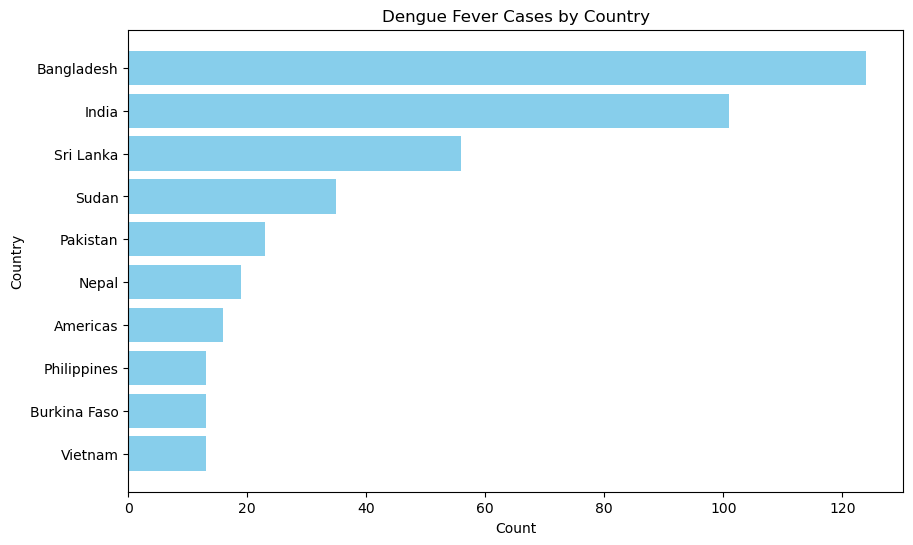

In [323]:
plt.figure(figsize=(10, 6))
plt.barh(Total_Dengue_country_count['Country'], Total_Dengue_country_count['Count'], color='skyblue')
plt.xlabel('Count')
plt.ylabel('Country')
plt.title('Dengue Fever Cases by Country')
plt.gca().invert_yaxis()  # Invert y-axis for descending order
plt.show()

In [311]:
Dengue_recent = Dengue_df[Dengue_df['Season'].isin(['2023-Summer','2023-Autumn','2024-Winter','2024-Spring'])]
Dengue_country_count = country_count(Dengue_recent['country_list']).sort_values(by='Count', ascending=False).head(10)
Dengue_country_count

,Country,Count
2,Bangladesh,53
0,India,31
1,Sri Lanka,17
12,Sudan,13
10,Burkina Faso,13
13,Mali,9
20,Americas,8
11,Africa,5
3,Nepal,4
28,Nigeria,4


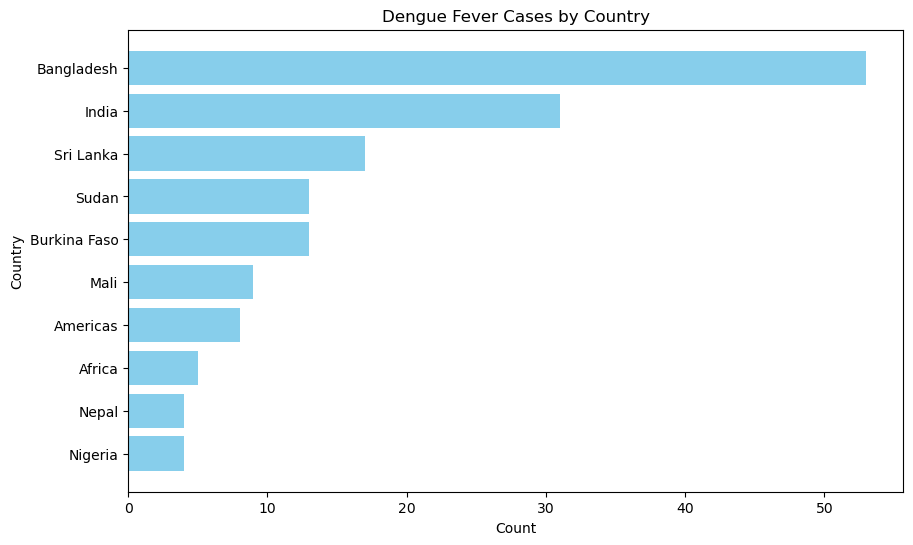

In [307]:
plt.figure(figsize=(10, 6))
plt.barh(Dengue_country_count['Country'], Dengue_country_count['Count'], color='skyblue')
plt.xlabel('Count')
plt.ylabel('Country')
plt.title('Dengue Fever Cases by Country')
plt.gca().invert_yaxis()  # Invert y-axis for descending order
plt.show()

C:\Users\ywy14\AppData\Local\Temp\ipykernel_11304\627174112.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_trend['Season'] = pd.Categorical(event_trend['Season'], categories=season_order, ordered=True)


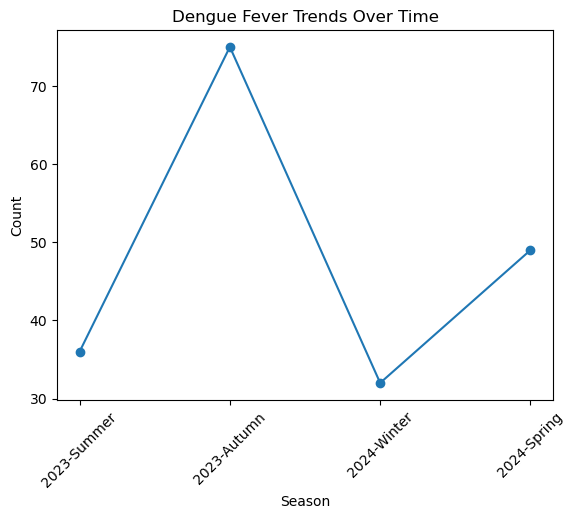

In [301]:
# Custom order for the seasons
season_order = [
    '2021-Winter', '2021-Spring', '2021-Summer', '2021-Autumn',
    '2022-Winter', '2022-Spring', '2022-Summer', '2022-Autumn',
    '2023-Winter', '2023-Spring', '2023-Summer', '2023-Autumn',
    '2024-Winter', '2024-Spring'
]

# Filter the data for 'Dengue fever' and only the specified seasons
event_trend = df_season_counts[(df_season_counts['Event'] == 'Dengue fever') & 
                               (df_season_counts['Season'].isin(['2023-Summer', '2023-Autumn','2024-Winter', '2024-Spring']))]

# Set Season as a categorical type with the custom order
event_trend['Season'] = pd.Categorical(event_trend['Season'], categories=season_order, ordered=True)

# Sort by the defined order
event_trend = event_trend.sort_values('Season')

# Plotting the data
plt.plot(event_trend['Season'], event_trend['Count'], marker='o')
plt.xlabel('Season')
plt.ylabel('Count')
plt.title('Dengue Fever Trends Over Time')
plt.xticks(rotation=45)
plt.show()

In [106]:
# cleaned_origs_promed = [remove_special_characters(text) for text in origs_promed]
# #en_texts = df_promed['description_en'].tolist()
# cleaned_origs_promed = remove_after_also_see(cleaned_origs_promed)
# #cleaned_origs_promed

In [107]:
# # 选择一个预训练的SBERT模型
# model_name_sim = 'paraphrase-multilingual-MiniLM-L12-v2'  # 支持多语言，包括中文
# model_sim = SentenceTransformer(model_name_sim)

In [108]:
# # 生成文本的嵌入
# model_sim.max_seq_length = 512
# embeddings_origs_promed = model_sim.encode(cleaned_origs_promed, convert_to_tensor=True)
# # 计算相似性矩阵
# cosine_scores_promed_origs = util.pytorch_cos_sim(embeddings_origs_promed, embeddings_origs_promed)

In [109]:
# result_origs_df_promed = pd.DataFrame(columns=['origs1_promed', 'origs2_promed', 'similarity_origs', 'index1_promed', 'index2_promed'])

In [110]:
# import tensorflow as tf
# gpus = tf.config.list_physical_devices("GPU")
# if gpus:
#     for gpu in gpus:
#         print("Found a GPU with the name:", gpu)
# else:
#     print("Failed to detect a GPU.")

In [111]:
# # 查找相似性过高的文本对
# threshold = 0.995 # 相似性阈值
# index = 0
# for i in range(0,60015):
#     for j in range(i+1, len(cleaned_origs_promed)):
#         similarity_origs_promed = cosine_scores_promed_origs[i][j].item()  # 转换为标量值
#         if similarity_origs_promed > threshold:
#             origs1_promed = cleaned_origs_promed[i]
#             origs2_promed = cleaned_origs_promed[j]
#             if (origs1_promed != "" and  origs2_promed != ""):
#                 index1_promed = i
#                 index2_promed = j
#                 result_origs_df_promed.loc[index] = [origs1_promed, origs2_promed, similarity_origs_promed, index1_promed, index2_promed]
#                 index += 1
#                 print(f"文本 '{i+1}'和'{j+1}'相似性为 {cosine_scores_promed_origs[i][j]:.4f}")

In [112]:
#cleaned_origs_promed[60014]

In [113]:
#cleaned_origs_promed[60069]

In [114]:
# # 查找相似性过高的文本对
# threshold = 0.995 # 相似性阈值
# index = 0
# for i in range(60014,60217):
#     for j in range(i+1, len(cleaned_origs_promed)):
#         similarity_origs_promed = cosine_scores_promed_origs[i][j].item()  # 转换为标量值
#         if similarity_origs_promed > threshold:
#             origs1_promed = cleaned_origs_promed[i]
#             origs2_promed = cleaned_origs_promed[j]
#             if (origs1_promed != "" and  origs2_promed != ""):
#                 index1_promed = i
#                 index2_promed = j
#                 result_origs_df_promed.loc[index] = [origs1_promed, origs2_promed, similarity_origs_promed, index1_promed, index2_promed]
#                 index += 1
#                 print(f"文本 '{i+1}'和'{j+1}'相似性为 {cosine_scores_promed_origs[i][j]:.4f}")

In [115]:
# # 查找相似性过高的文本对
# threshold = 0.995 # 相似性阈值
# index = 0
# for i in range(60216,len(cleaned_origs_promed)):
#     for j in range(i+1, len(cleaned_origs_promed)):
#         similarity_origs_promed = cosine_scores_promed_origs[i][j].item()  # 转换为标量值
#         if similarity_origs_promed > threshold:
#             origs1_promed = cleaned_origs_promed[i]
#             origs2_promed = cleaned_origs_promed[j]
#             if (origs1_promed != "" and  origs2_promed != ""):
#                 index1_promed = i
#                 index2_promed = j
#                 result_origs_df_promed.loc[index] = [origs1_promed, origs2_promed, similarity_origs_promed, index1_promed, index2_promed]
#                 index += 1
#                 print(f"文本 '{i+1}'和'{j+1}'相似性为 {cosine_scores_promed_origs[i][j]:.4f}")

In [116]:
#result_origs_df_promed.to_csv("sim_origs_promed.csv", index=False,encoding='utf-8-sig')

In [117]:
#df_year_1 = df_year.drop(columns=["disease_pathogen",'lang','is_virus_related', 'is_drug_resist', 'is_vector_borne', 'is_respiratory', 'is_unknown_disease', 'is_multi_countries', 'is_human_disease', 'death_count'])

In [118]:
#df_year_1.head()

In [119]:
# # Define the cutoff date
# end_date = datetime(2023, 12, 31)

# # Calculate the start date (one year before the cutoff date)
# start_date = datetime(2023, 1, 1)

# # Filter the DataFrame
# df_year_2023 = df_promed[(df_promed['date_published'] >= start_date) & (df_promed['date_published'] <= end_date)]

In [120]:
#df_year_2023 = df_year_2023.drop(columns=["disease_pathogen",'lang','is_virus_related', 'is_drug_resist', 'is_vector_borne', 'is_respiratory', 'is_unknown_disease', 'is_multi_countries', 'is_human_disease', 'death_count'])

In [121]:
#df_year_2023

In [122]:
#df_year_2023.to_csv("promed_2023.csv", index=False,encoding='utf-8-sig')

In [123]:
#df_year.to_csv("promed_year.csv", index=False,encoding='utf-8-sig')

In [124]:
# file_path_2='promed_2023.csv'
# df_year_2023 = pd.read_csv(file_path_2)

In [125]:
#origs_promed_2023 = df_year_2023['content_orig'].tolist()

In [126]:
# def extract_date(text):
#     match = re.search(r'Date: (\w+ \d+ \w+ \d{4})', text)
#     if match:
#         return match.group(1)
#     return None

In [127]:
# df_year_2023['str_source_date'] = df_year_2023['content_orig'].apply(extract_date)

In [128]:
# df_year_2023.info()

In [129]:
# a=df_year_2023[df_year_2023['str_source_date'].isna()]
# a

In [130]:
#b=a['content_orig'].tolist()

In [131]:
#b[2]